This report contains, in addition to the code provided by the lecturer, my own code changes and addition, and written answers to answer coursework 8 in Machine Learning and Statistics. The answer for assignment 1 starts at page 5, and so on.

In [29]:
# Load the libraries needed
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import time

# Seed random number generator
np.random.seed(123)

# Helper functions for polynomials
def powers( X, n ):
    """ Returns an array of the powers of the elements of X up to the nth power """
    return np.power(np.expand_dims(X, axis=-1), [np.arange(n)])

def polynomial( X, poly_coeff ):
    """ Returns the value of a polynomial at x with given coefficients """
    deg = np.shape(poly_coeff)[-1]
    return np.dot(powers(X, deg), np.transpose(poly_coeff), )

def fit_polynomial( X, y, n ):
    """ Returns the coefficients of the n-degree polynomial fit to (X, y) """
    X_pwrs = powers(X, n+1)
    # Do linear least squares fit
    coeff, _, _, _ = np.linalg.lstsq(X_pwrs, y, rcond=None)
    return coeff


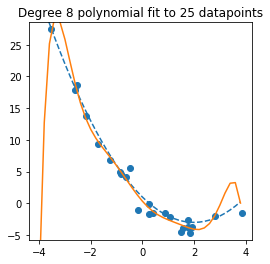

In [2]:
# Demonstration of polynomial models fit to example datapoints
# You should experiment with different model degrees and different 
# numbers of sampled datapoints to get a feel for how the degree of
# the model affects the 'fit' of the model.

# Example data
example_coefficients = [ 1., -4., 1. ]
eps_std = 1.0
num_samples = 25

X = np.random.uniform(-4., 4., size=num_samples) # generate sample points
eps = np.random.normal(scale=eps_std, size=num_samples) # generate noise
y = polynomial(X, example_coefficients) + eps # generated targets


# Fit polynomial to data
poly_deg = 8
learned_coefficients = fit_polynomial( X, y, poly_deg )

#Plot the data
plt.figure(figsize=(4,4))
plt.scatter(X,y)
plt.ylim(y.min()-1., y.max()+1.)

# Make sequence of x-values for plotting
axis_X = np.arange(-4.0, 4.0, 0.2)

#Plot the true polynomial
poly_y = polynomial(axis_X, example_coefficients)
plt.plot(axis_X, poly_y, '--')

#Plot the learned polynomial
poly_y = polynomial(axis_X, learned_coefficients)
plt.plot(axis_X, poly_y, )

plt.title("Degree {:d} polynomial fit to {:d} datapoints".format(poly_deg, num_samples))

plt.show()

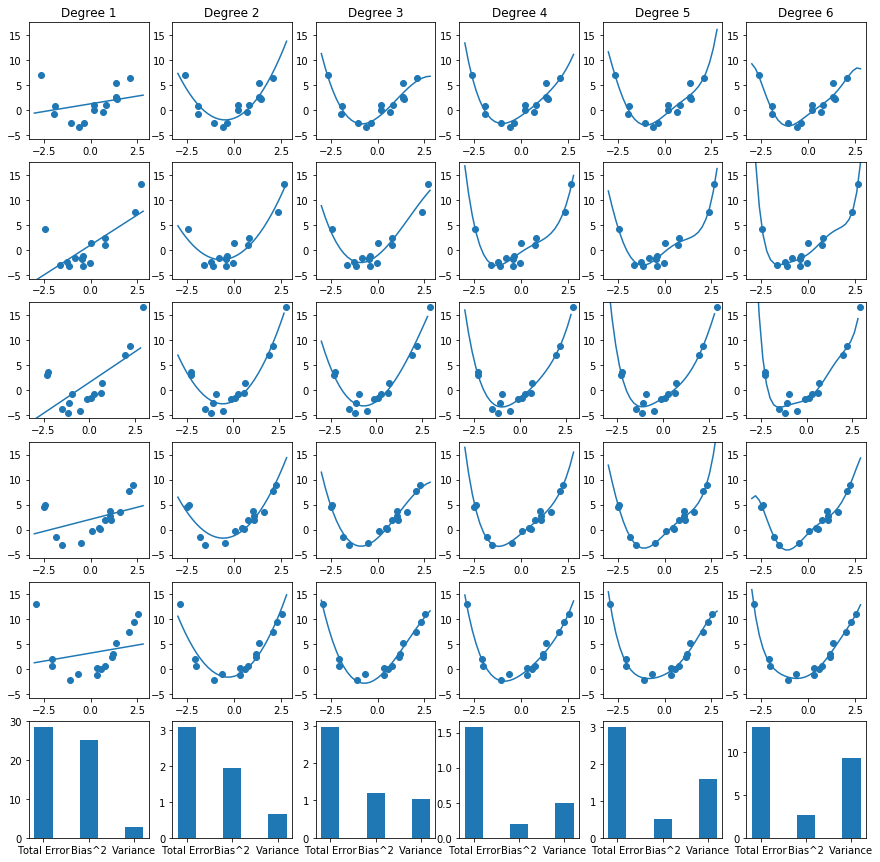

In [3]:
# Bias-variance trade-off
# You should run the code below and observe how different polynomial
# models behave on resamplings of the same data. Also observe how
# the caclulated bias and variance relate to the total prediction
# error.

#Visualise different degree polynomials on different data
num_resamplings = 5
polynomial_degrees = [ 1, 2, 3, 4,5,6 ]

# Load saved data
X, y, test_X, test_y, test_y_gt = np.load("./class8_generated_data.npy")

# Plots for plotting
fig, subplots = plt.subplots(nrows=num_resamplings+1,
                             ncols=len(polynomial_degrees),
                             figsize=(15, 15), )

folds_X = np.split(X, num_resamplings)
folds_y = np.split(y, num_resamplings)
#folds_eps = np.split(eps, num_resamplings)

# Make sequence of x-values for plotting
axis_X = np.arange(-3.0, 3.0, 0.2)

# Functions for estimating mse, bias, and variance from a set of learned params
def bias_sq(x, learned_coeffs, true_y):
    mean_y = np.mean(polynomial(x, learned_coeffs), axis=-1)
    return np.square(mean_y - true_y)

def variance(x, learned_coeffs):
    return np.var(polynomial(x, learned_coeffs), axis=-1)

def square_error(x, learned_coeffs, y):
    pred_y = polynomial(x, learned_coeffs)
    return np.square(pred_y - np.expand_dims(y, -1))
    
for j, n in enumerate(polynomial_degrees):
    
    # Placeholder for learned coefficients
    learned_coefficients = np.zeros((num_resamplings, n+1),)
    
    for i in range(num_resamplings):
        # Get ith subsample of data
        sub_X = folds_X[i]
        sub_y = folds_y[i]
        
        # Plot the data
        subplots[i,j].set_ylim([y.min()-1., y.max()+1.])
        subplots[i,j].scatter(sub_X, sub_y)
        
        # Fit polynomial to data
        learned_coefficients[i] = fit_polynomial( sub_X, sub_y, n )

        # Plot the learned polynomial
        poly_y = polynomial(axis_X, learned_coefficients[i])
        subplots[i,j].plot(axis_X, poly_y, )
    
    # Add titles
    subplots[0,j].set_title("Degree {:d}".format(n))
    
    # Plot MSE, bias squared, and variance
    mse = np.mean(square_error(test_X, learned_coefficients, test_y))
    bias = np.mean(bias_sq(test_X, learned_coefficients, test_y_gt))
    var = np.mean(variance(test_X, learned_coefficients))
    subplots[-1,j].bar([-2, .0, 2], [mse, bias, var], )
    subplots[-1,j].set_xticklabels(('','Total Error', 'Bias^2', 'Variance'))
    
plt.show()

# Assignment 1: 

Run the code provided and look at the plots of polynomials of different degrees fit to multiple samples randomly drawn from the data set. With the experimental evidence and your justification, comment on (i)how the bias and variance relate to a degree of the polynomial and (ii)which polynomial degree has been used to generate the data set. <br>

Answer: <br>

 - (i) From the plots above we see that the bias decreases and the variance increases as the degree of polynomials used increase. I.e. as the model complexity increases the bias decreases and the variance increases. This is because a more complex model with more flexibility, i.e. here the ones with more polynomials, will be more affected by the specifics of the training data, and thus the variance across training datasets becomes bigger. For the less complex models with less flexibility the variance will be similar across training datasets as it cannot to the same degree "catch" the details of the data. For the bias on the other hand, this will decrease as the number of polynomials increase as the more complex models are better at predicting the actual values in the datase (the specifics). A polynomial for degree 1 or 2 will for instance not have the flexibility to predict a lot of the data specifics and will thus be very "off" in many cases - as the graphs above shows. The result is a higher bias. <br>
 - (ii) By testing with several different degrees of polynomials as the plots above show, we see that the total error is at its smallest when the degree is set to 4. This means, as we can see by the plots, that this is the polynomial which gives the lowest values for Bias and Variance errors. Based on this we can argue that 4 is the polynomial degree that probably has been used to  generate the dataset.

In [8]:
# Cross-validation
# Run the following code to see the results of 5-fold cross-validation
# for fitting a linear model to historical FTSE 100 prices. To modify
# this code to change it to LOOCV, change the number of folds (given
# by the variable num_folds) to the number of items in the dataset X, y.
# Experiment with a degree 3 polynomial model by changing the variable
# model_degree to 3.

# Load data
ftse_prices = []
with open('./class8_data_FTSE100.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='\"')
    _ = next(csvreader) # skip the header row
    for row in csvreader:
        ftse_prices.append(float(row[1].replace(',','')) / 1e3)
ftse_prices.reverse()
y = np.array(ftse_prices) # 1e-3 * price of ftse
X = np.arange(np.size(y)) # number of months since start


# K-fold cross validation
num_folds = 5
model_degree = 3

#Plot the data
plt.figure(figsize=(4,4))
plt.scatter(X,y)
plt.ylim(y.min()-1., y.max()+1.)

#Plot the fitted polynomial
best_fit_coeff = fit_polynomial(X, y, model_degree)
plt.plot(X, polynomial(X, best_fit_coeff) )

plt.ylabel("Price (£x1000)")
plt.xlabel("Months since September 2008")
plt.title("FTSE 100 index price")

plt.show()

# Shuffle data
np.random.shuffle(X) 
y = y[X] # we abuse the fact that X is just the index of y to ensure they stay matched up

# Helper function for getting folds
def get_fold(X, y, fold, num_folds):
    folds_X = np.array_split(X, num_folds)
    test_X = folds_X.pop(fold)
    train_X = np.concatenate(folds_X)
    
    folds_y = np.array_split(y, num_folds)
    test_y = folds_y.pop(fold)
    train_y = np.concatenate(folds_y)
    return train_X, train_y, test_X, test_y

print("Running cross validation on polynomial model of degree {:d}".format(model_degree))
start_t = time.time()
total_loss = 0.

losses = []

for i in range(num_folds):
    #Get data for fold
    train_X, train_y, test_X, test_y = get_fold(X, y, i, num_folds)

    #Fit model
    learned_coefficients = fit_polynomial( train_X, train_y, model_degree )
    
    #Calculate loss
    pred_y = polynomial(test_X, learned_coefficients)
    fold_loss = np.square(pred_y - test_y)
    mean_fold_loss = np.mean(fold_loss)
    
    losses.append(mean_fold_loss)
    
    print("Mean loss for fold {:d}/{:d}: {:.5f}".format(i+1, num_folds, mean_fold_loss))

end_t = time.time()
elapsed_t_ms = (end_t - start_t) * 1e3
print("Completed {:d} folds in {:.2f} milliseconds. \n".format(num_folds, elapsed_t_ms))

#The code below was used when running LOOCV with d=1 and 
#d=3 resepectively to store the 
#arrays of errors, for use later in assignment 3 and 4

#losses_d1= losses
#losses_d3 = losses

Running cross validation on polynomial model of degree 3
Mean loss for fold 1/5: 0.12158
Mean loss for fold 2/5: 0.14398
Mean loss for fold 3/5: 0.09928
Mean loss for fold 4/5: 0.08322
Mean loss for fold 5/5: 0.07757
Completed 5 folds in 2.00 milliseconds. 



# Assignment 2: 

For each of the two polynomial models (d = 1 or d = 3), record the approximate
time spent by using 5-fold cross validation and LOOCV, respectively. Based on the experimental
results, comment on the difference between the two cross-validation methods in terms of computational
efficiency. <br>

Answer: <br> 

Approximate time spent for each case: <br>

 - 5-fold cross validation, d=1: Average across 5 runs was 15.8 milliseconds <br>
 - 5-fold cross validation, d=3: Average across 5 runs was 12.4 milliseconds <br>
 - LOOCV, d=1: Average across 5 runs was 153 milliseconds <br>
 - LOOCV, d=3: Average across 5 runs was 105.8 milliseconds <br>

We see from the approximate times above that LOOCVs spend more times to complete than 5-fold CV. The reason for this is that the K represents the number of parts we split the data into and thus the number of times a new model will be fit. With 5-fold CV we have set K=5, and with LOOCV we set the K equal to the length of the dataset (len(X)). In this case this meant that with LOOCV the model had to be fit 120 times, which is more comuptationally intensive and thus takes more time.

# Assignment 3: 

For each of the two polynomial models (d = 1 or d = 3), calculate the average, and
standard-deviation, of the mean square error loss on the validation set using LOOCV and record
your results. <br>

Answer: <br>

In [9]:
#We here use losses_d1 and lossed_d3 which is included in the code above.
#The arrays holds the arrays of losses from running LOOCV with d=1 and d=3 

print(round(np.mean(losses_d1),3))
print(round(np.std(losses_d1),3))

0.141
0.185


In [10]:
print(round(np.mean(losses_d3),3))
print(round(np.std(losses_d3),3))

0.104
0.112


 - d=1: <br>
 Average: 0.141 <br>
 Standard-deviation: 0.185 <br>
 
 - d=3: <br>
 Average: 0.104 <br>
 Standard-deviation: 0.112 <br>

# Assignment 4: 

With the evidence and your justification, comment on whether the difference between
the mean square errors of two models achieved in Assignment 3 is statistically significant.
Be sure to include your code used for your justification in your report. (Hint: the scipy.stats
module may be useful for this assignment.) <br> 

Answer: <br>

To check what kind of test we can use on our data we have to test for normality first. We do this using a function from scipy.stats and by plotting for a visual inspection. The function from Scipy.stats tests the null hypothesis that the data is normally distributed. If the p-value is greater than 0.05 we cannot reject the null hypothesis.

76.39377581815572 2.578115412692844e-17
It is unlikely normal


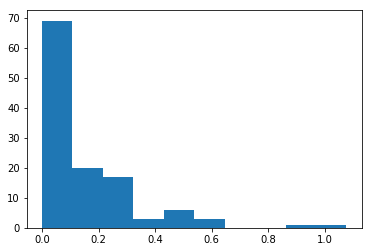

In [11]:
from matplotlib import pyplot
from scipy.stats import normaltest

value, p = normaltest(losses_d1)
print(value, p)
if p >= 0.05:
    print('It is likely normal')
else:
    print('It is unlikely normal')

    
plt.hist(losses_d1)
pyplot.show()

52.277360610892075 4.447494084493847e-12
The data is unlikely normal normally distributed


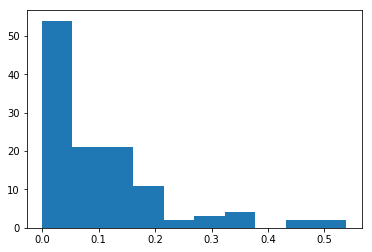

In [27]:
value, p = normaltest(losses_d3)
print(value, p)
if p >= 0.05:
    print('The data is likely normally distributed')
else:
    print('The data is unlikely normal normally distributed')
 
plt.hist(losses_d3)
pyplot.show()

As we can see neither of our data for d=1 and d=3 is normally distributed. <br>

Morover, many tests are based on the assumption that the samples to be tested are unpaired. But as we have tested our two models on exactly the same training and test data, our samples can be said to be unpaired (2). Overall, we have to choose a test which is not based on the assumptions of a normal distribution or being unpaired.  <br>

Wilcoxon Signed-Rank test is a non-parametric test (does not assume a normal distribution) for paired/related data (2). The null hypothesis is that the two samples are drawn from the same  distribution. If we find that the p-value is larger than 0.05 we can reject the null hypothesis and conclude that the difference between the mean square errors of the two models is statistically significant. <br>

In [28]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(losses_d1, losses_d3)
print(round(stat,2), round(p,2))

alpha = 0.05
if p > alpha:
    print('Likely same distribution - cannot to reject null hypothesis')
else:
    print('Likely different distribution - reject null hypothesis')

3386.0 0.52
Likely same distribution - cannot to reject null hypothesis


As the results above shows, the test does not support that the difference between the mean squared errors of the two models are is significantly different.

# Resources

(1) https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/ <br> 
(2) https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/ <br> 